# Libraries

In [1]:
import pandas as pd
import numpy as np 
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  
from sklearn.preprocessing import StandardScaler, LabelBinarizer ,OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import joblib

# Read Data

In [2]:
Covid_data = pd.read_csv("data.csv" , index_col = 0)
print(" the shape of the data  = ", Covid_data.shape)
Covid_data.head()

 the shape of the data  =  (863, 14)


,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


# Split data into features and labels

In [3]:
X = Covid_data.iloc[:,:-1]                #independent columns
y =  Covid_data.iloc[:,-1]    #target column i.e price range

# Visualize Correlation of each feature in the data

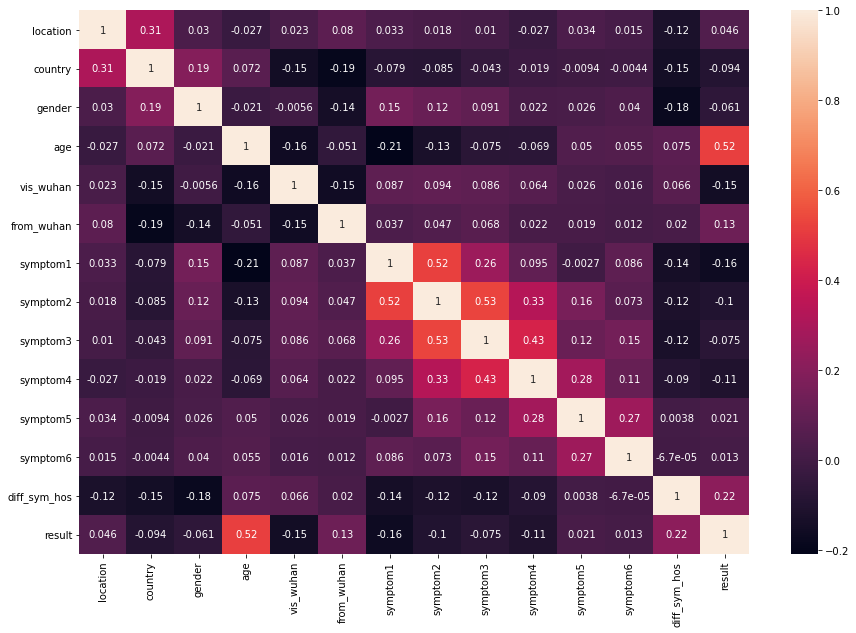

In [4]:
#get correlations of each features in dataset
corrmat = Covid_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,10))
#plot heat map
g=sns.heatmap(Covid_data[top_corr_features].corr(),annot=True)

# Select the most important Features 

[9.91040996e-02 9.90946044e-02 5.33864782e-02 4.96786657e-01
 2.39679707e-02 2.92533630e-02 4.28439826e-02 2.94606777e-02
 1.70806762e-02 1.18975726e-02 4.32570623e-04 1.33609877e-04
 9.65577378e-02]


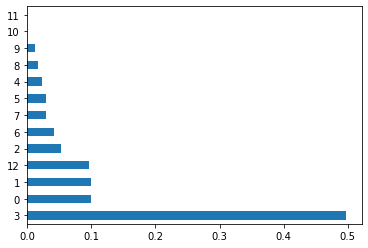

In [5]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_)
feat_importances.nlargest(X.shape[1]).plot(kind='barh')
plt.show()

In [6]:
print(" The importance of each feature = ", feat_importances.nlargest(X.shape[1]))
# As you  see there is 2 Feature don't have any effect we can remove them and take only 10 feature which have the highest score (Drop symptom5 And symptom6)
X_important = Covid_data.iloc[:,feat_importances.nlargest(10).index]


 The importance of each feature =  3     0.496787
0     0.099104
1     0.099095
12    0.096558
2     0.053386
6     0.042844
7     0.029461
5     0.029253
4     0.023968
8     0.017081
9     0.011898
10    0.000433
11    0.000134
dtype: float64


In [7]:
X_important

,age,location,country,diff_sym_hos,gender,symptom1,symptom2,from_wuhan,vis_wuhan,symptom3
0,66.0,104,8,8,1,14,31,0,1,19
1,56.0,101,8,0,0,14,31,1,0,19
2,46.0,137,8,13,1,14,31,1,0,19
3,60.0,116,8,0,0,14,31,0,1,19
4,58.0,116,8,0,1,14,31,0,0,19
...,...,...,...,...,...,...,...,...,...,...
858,24.0,48,3,0,2,14,31,0,0,19
859,35.0,0,0,0,2,14,31,0,0,19
860,49.4,3,1,0,1,14,31,0,0,19
861,49.4,24,9,0,1,14,31,0,0,19


# Split data into train and test 

In [8]:
train_ratio = 0.9
# train is now 90% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(X_important,y, test_size=1 - train_ratio ,random_state = 42 , shuffle =True , stratify=y)


# Select The Best Combination of hyperparameters for each model Using Cross Validation and 

In [9]:

def Best_hyperparameter_model(model , parameters ,  k_fold , model_name , X_train , Y_train , Y_test ,X_test):
  
  param_size = ParameterGrid(parameters)
  print("parameters in {} model = ".format( model_name), len(param_size))
  grid_search = GridSearchCV(model, parameters, cv= k_fold,scoring='f1' ,n_jobs=-1 , verbose = 3)
  print(grid_search)
  grid_result= grid_search.fit(X_train, Y_train)
  Y_predict = grid_result.predict(X_test)

  precision , recall , fscore , _ = precision_recall_fscore_support(Y_test, Y_predict, average='binary')
  Y_predict_prob = grid_result.predict_proba(X_test)
  False_Pos_Rate,True_Pos_Rate, thresh = metrics.roc_curve(Y_test,Y_predict_prob[:,1])
  auc = metrics.auc(False_Pos_Rate, True_Pos_Rate)
  

  plt.plot(False_Pos_Rate,True_Pos_Rate, label='ROC curve (area = %.2f)' %auc)
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid()
  plt.legend()
  plt.show()


  print('Best Params: ', grid_result.best_params_)
  print('Best Score: ', grid_result.best_score_)
  print('Test set accuracy:' , metrics.accuracy_score(np.array(Y_test).reshape(-1,1), Y_predict))
  print('Train set accuracy:' , metrics.accuracy_score(np.array(Y_train).reshape(-1,1), grid_result.predict(X_train)))
  print("AUC:", auc , " precision : " ,precision , " recall : " , recall , "FScore : ", fscore) 
  
 
  
  return precision , recall , fscore , auc , grid_search




parameters in knn model =  60
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 21, 2), 'p': [3, 2, 1],
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=3)
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.6s finished


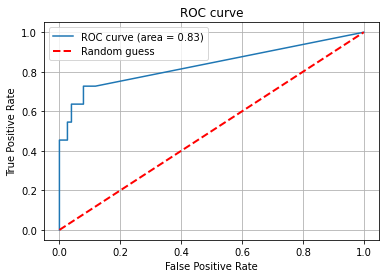

Best Params:  {'n_neighbors': 5, 'p': 3, 'weights': 'distance'}
Best Score:  0.7955187303069202
Test set accuracy: 0.9080459770114943
Train set accuracy: 1.0
AUC: 0.8343301435406698  precision :  0.7142857142857143  recall :  0.45454545454545453 FScore :  0.5555555555555556
parameters in Logistic model =  14400
GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': range(1, 21),
                         'class_weight': ['dict', 'balanced', 'none'],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga'],
                         'tol': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                                 0.08, 0.09]},
             scoring='f1', verbose=3)
Fitting 5 folds for each of 14400 candidates, totalling 72000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2164 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 7284 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 14452 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 23668 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 34932 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 48244 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 63604 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 72000 out of 72000 | elapsed:  1.7min finished


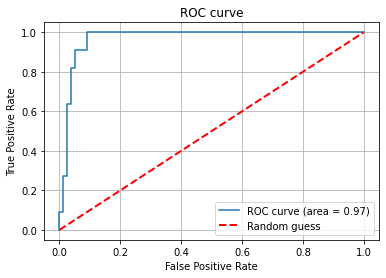

Best Params:  {'C': 11, 'class_weight': 'dict', 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.09}
Best Score:  0.7755555555555556
Test set accuracy: 0.9080459770114943
Train set accuracy: 0.9536082474226805
AUC: 0.9677033492822967  precision :  0.7142857142857143  recall :  0.45454545454545453 FScore :  0.5555555555555556
parameters in Decision_Tree model =  129600
GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['dict', 'list of dict', 'balanced',
                                          'none'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 10),
                         'max_features': ['auto', 'sqrt', 'log2', 'none'],
                         'max_leaf_nodes': ['none', 2, 10, 20, 5],
                         'min_samples_leaf': [1, 2, 5, 10, 15],
                         'min_samples_split': [2, 5, 10, 20, 50, 100],
                         'splitter

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 3572 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 13812 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 28148 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 46580 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 69108 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 95732 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 126452 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 161268 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200180 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 243188 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 290292 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 341492 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 396788 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: D

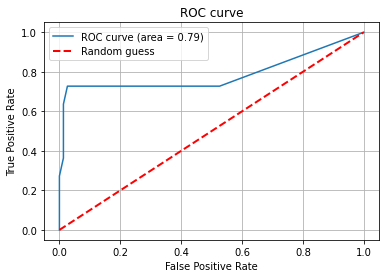

Best Params:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Best Score:  0.8479741917908813
Test set accuracy: 0.896551724137931
Train set accuracy: 0.9368556701030928
AUC: 0.7858851674641149  precision :  0.5714285714285714  recall :  0.7272727272727273 FScore :  0.64
parameters in Naive_Bayes model =  100
GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished


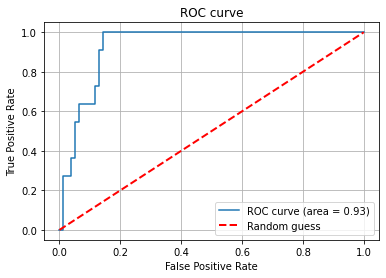

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Best Params:  {'var_smoothing': 3.5111917342151275e-06}
Best Score:  0.5966815244201451
Test set accuracy: 0.8850574712643678
Train set accuracy: 0.875
AUC: 0.9294258373205742  precision :  0.5384615384615384  recall :  0.6363636363636364 FScore :  0.5833333333333334
parameters in SVM model =  864
GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': range(1, 10),
                         'class_weight': ['dict', 'balanced', 'none'],
                         'degree': [2, 1, 3, 4], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             scoring='f1', verbose=3)
Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1272 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2225 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3338 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4309 out of 4320 | elapsed:  8.1min remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  8.3min finished


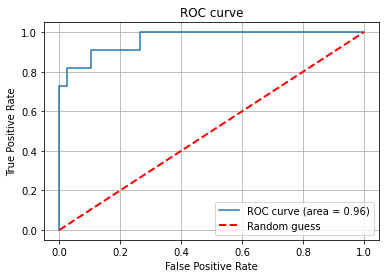

Best Params:  {'C': 1, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}
Best Score:  0.8497032048830718
Test set accuracy: 0.9540229885057471
Train set accuracy: 1.0
AUC: 0.9641148325358851  precision :  1.0  recall :  0.6363636363636364 FScore :  0.7777777777777778


In [10]:
knn_parameters ={'n_neighbors': range(1, 21, 2),'p' : [3 , 2 , 1],'weights' : ['uniform', 'distance'] }
DT_parameters = { 'criterion' :['gini', 'entropy', 'log_loss'] , 'splitter' : ['best', 'random'] , 'max_depth' : range(1,10,1) ,'min_samples_split' :[2 ,5, 10, 20, 50, 100] , 'min_samples_leaf' : [ 1 ,2 , 5 , 10 ,15] , 'max_features' : ['auto', 'sqrt', 'log2' ,'none'] , 'max_leaf_nodes':['none' , 2 , 10 , 20 , 5 ] , 'class_weight' : [ 'dict', 'list of dict','balanced', 'none']}
log_parameters ={'penalty': ['l1', 'l2', 'elasticnet',  'none'],'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],'C' : range(1, 21, 1) , 'tol' : [x / 100 for x in range(0, 10)]  , 'class_weight' : ['dict' , 'balanced', 'none'] }
SVM_parameters = {'C': range(1,10) , 'gamma': ['scale' , 'auto'], 'kernel': ['rbf' , 'linear', 'poly', 'sigmoid'] , 'degree' : [2,1,3,4] , 'class_weight': ['dict', 'balanced' , 'none'] }
Naive_parameters = {'var_smoothing' : np.logspace(0,-9, num=100)}

SVM_model = SVC(probability = True)
KNN_MODEL = KNeighborsClassifier()
Logistic_MODEL = LogisticRegression()
DT_MODEL = DecisionTreeClassifier()
Naive_Model =  GaussianNB()

parameters_list = [ knn_parameters ,log_parameters , DT_parameters , Naive_parameters , SVM_parameters ]
models_list = [ KNN_MODEL ,Logistic_MODEL , DT_MODEL  , Naive_Model ,SVM_model]
name_models_list =  ['knn' , 'Logistic' , 'Decision_Tree' , 'Naive_Bayes' ,'SVM']
evaluation_list_models= []
k_folds= 5
save_models = []
# k_folds = StratifiedKFold(5).split(x_train, y_train)
for i in range(len(parameters_list)):
    precision , recall , fscore , auc , model = Best_hyperparameter_model( models_list[i] , parameters_list[i] ,  k_folds , name_models_list[i] , x_train , y_train , y_test , x_test)
    evaluation_list_models.append([precision , recall , fscore , auc])
    ##########################
    # SAVE-LOAD using joblib #
    ##########################
    save_models.append(joblib.dump(model, "model_{}v12.pk".format(name_models_list[i])))



# Load Models 

classification_report of knn
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        76
           1       0.71      0.45      0.56        11

    accuracy                           0.91        87
   macro avg       0.82      0.71      0.75        87
weighted avg       0.90      0.91      0.90        87

classification_report of Logistic
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        76
           1       0.71      0.45      0.56        11

    accuracy                           0.91        87
   macro avg       0.82      0.71      0.75        87
weighted avg       0.90      0.91      0.90        87

classification_report of Decision_Tree
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        76
           1       0.57      0.73      0.64        11

    accuracy                           0.90        87
   macro avg       0.77   

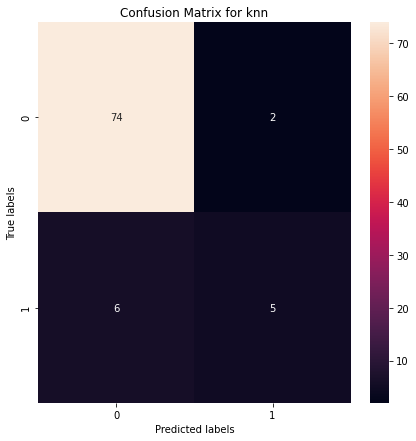

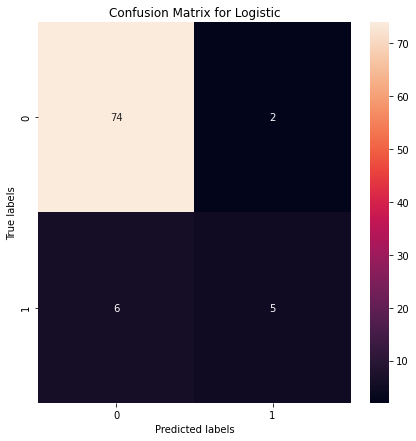

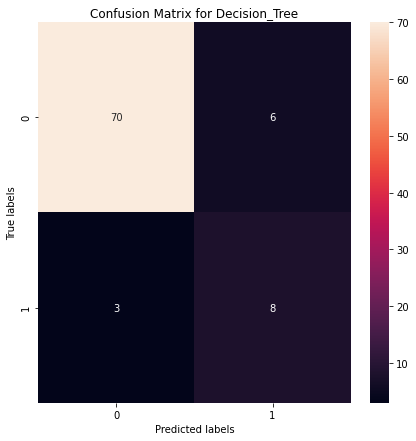

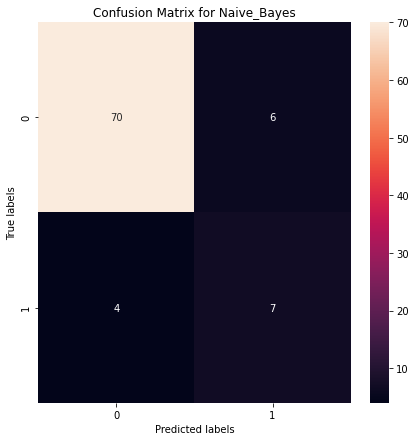

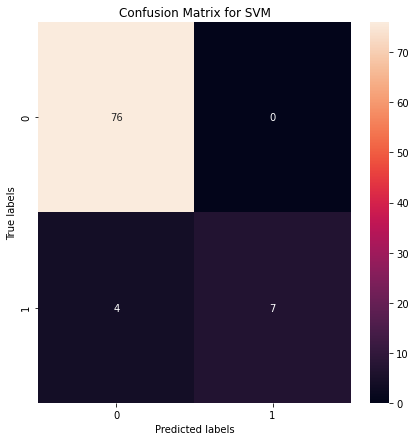

In [14]:
# load models
models=[]
for i in range(len(name_models_list)):
    model = joblib.load( "model_{}v12.pk".format(name_models_list[i]))
    pred = model.predict(x_test)
    report = classification_report(y_test, pred)
    cm = confusion_matrix(y_test, pred)
    print("classification_report of " + name_models_list[i] )
    print(report)
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt='g')  
    # labels, title and ticks
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for {}'.format(name_models_list[i]))
    
    models.append(model)


# Visualize Confusion matrix for each model 

In [15]:
column_names = ["Classifier", "precision","Recall","F1 score","ROC/AUC"]

Data = [[name_models_list[i]]+evaluation_list_models[i] for i in range(len(evaluation_list_models))]

comparision_classifier = pd.DataFrame(Data , columns = column_names)

comparision_classifier

,Classifier,precision,Recall,F1 score,ROC/AUC
0,knn,0.714286,0.454545,0.555556,0.834330
1,Logistic,0.714286,0.454545,0.555556,0.967703
2,Decision_Tree,0.571429,0.727273,0.640000,0.785885
3,Naive_Bayes,0.538462,0.636364,0.583333,0.929426
4,SVM,1.000000,0.636364,0.777778,0.964115


In [16]:
comparision_classifier.to_csv('comparision_classifier_balance_classes.csv')

<AxesSubplot:xlabel='Classifier'>

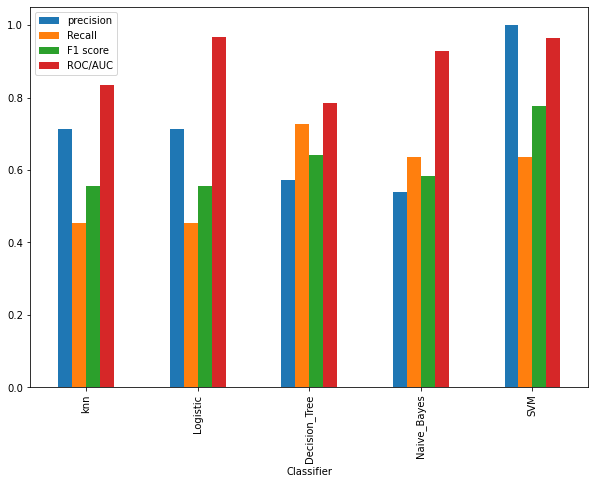

In [17]:
comparision_classifier.plot(x='Classifier',kind="bar",figsize=(10,7))

   # Visualize Evalution Matrices For each model 

In [20]:
def plot_evalution_matrices(list_evalution_models , scoring_name , list_name_models):

    plt.plot(list_name_models , np.array(evaluation_list_models)[:,0])
    plt.plot(list_name_models , np.array(evaluation_list_models)[:,1])
    plt.plot(list_name_models , np.array(evaluation_list_models)[:,2])
    plt.plot(list_name_models , np.array(evaluation_list_models)[:,3])
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title("Comparison plot")
    plt.legend([scoring_name[1] , scoring_name [2] , scoring_name [3] , scoring_name[4]])
    plt.show()


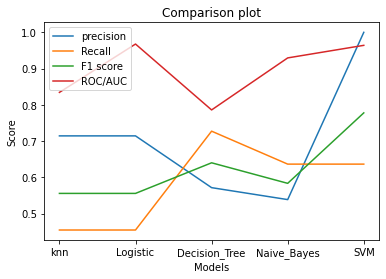

In [21]:
 plot_evalution_matrices(evaluation_list_models , column_names , name_models_list)